Importing the dependencies.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

 Load the Data.

In [37]:
dataset_1 = pd.read_csv('B:/Projects/Movie Reccomendation System/tmdb_5000_credits.csv.zip')
dataset_2 = pd.read_csv('B:/Projects/Movie Reccomendation System/tmdb_5000_movies.csv.zip')

 Joining two datasets on the "id" coloumn.

In [38]:
dataset_1.columns = ['id','tittle','cast','crew']
dataset_2 = dataset_2.merge(dataset_1,on='id')

Just a peak at the data

In [39]:
dataset_2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# Demographic filtering

We already have v(vote_count) and R(vote_average) and C can be calculated as


In [40]:
C = dataset_2['vote_average'].mean()
C

6.092171559442016

Calculating an appropiate value for the m, the minimnum votes required to be listed in the chart.
In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [41]:
m= dataset_2['vote_count'].quantile(0.9)
m

1838.4000000000015

Now, filtering the movies that qualify for the chart.

In [42]:
qualify_movies = dataset_2.copy().loc[dataset_2['vote_count'] >= m]
qualify_movies.shape

(481, 23)

We see that there are 481 movies which qualify to be in this list. Now,calculating our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to DataFrame of qualified movies.


In [43]:
def weighted_rating(x , m=m , C=C) :
    v = x['vote_count']
    R = x['vote_average']
    #IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C) 

In [44]:
qualify_movies['score'] = qualify_movies.apply(weighted_rating, axis=1)

Sorting the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [45]:
qualify_movies = qualify_movies.sort_values('score', ascending=False)

#Print the top 15 movies
qualify_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Under the Trending Now tab of these systems we find movies that are very popular and they can just be obtained by sorting the dataset by the popularity column.

Text(0.5, 1.0, 'Popular Movies')

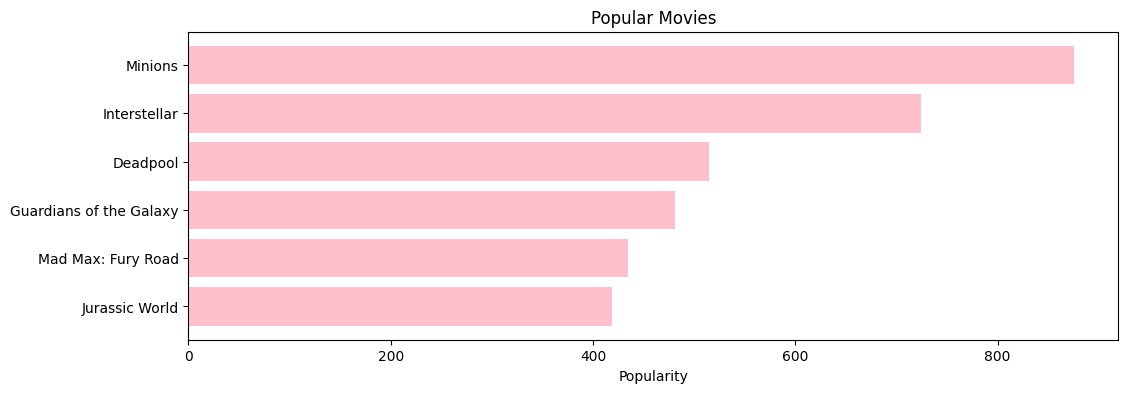

In [46]:
pop = dataset_2.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='pink')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# Contained-based filtering

Plotting Description Based recommender

In [47]:
dataset_2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

Computing Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

In [48]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
dataset_2['overview'] = dataset_2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(dataset_2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

Using the TF-IDF vectorizer, calculating the dot product will directly give the cosine similarity score. Therefore, using sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [49]:
Cosine_similarity_score = linear_kernel(tfidf_matrix ,tfidf_matrix)

Constructing a reverse map of movie titles and indices

In [50]:
indices = pd.Series(dataset_2.index, index=dataset_2['title']).drop_duplicates()

In [51]:
 #Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=Cosine_similarity_score):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return dataset_2['title'].iloc[movie_indices]

In [52]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

In [53]:
get_recommendations('Batman Returns')

3                         The Dark Knight Rises
3854    Batman: The Dark Knight Returns, Part 2
65                              The Dark Knight
299                              Batman Forever
1359                                     Batman
119                               Batman Begins
9            Batman v Superman: Dawn of Justice
210                              Batman & Robin
1309                              Heartbreakers
504                     The Secret Life of Pets
Name: title, dtype: object

Credits, Genres and Keywords Based Recommender

In [54]:
features = ['cast' , 'crew' , 'keywords' , 'genres']
for feature in features :
    dataset_2[feature] = dataset_2[feature].apply(literal_eval)


Defining functions that will help to extract the required information from each feature.

In [55]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [56]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [57]:
dataset_2['director'] = dataset_2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    dataset_2[feature] = dataset_2[feature].apply(get_list)

In [58]:
dataset_2[['title' , 'cast' , 'director' , 'keywords' , 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [59]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [60]:
# Applying clean_data function to our features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    dataset_2[feature] = dataset_2[feature].apply(clean_data)

Creating our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer.

In [61]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
dataset_2['soup'] = dataset_2.apply(create_soup, axis=1)

Using CountVectorizer()

In [62]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(dataset_2['soup'])

In [63]:
# Computing the Cosine Similarity matrix based on the count_matrix
cosine_similarity_score_2 = cosine_similarity(count_matrix, count_matrix)

In [64]:
dataset_2 = dataset_2.reset_index()
indices = pd.Series(dataset_2.index, index=dataset_2['title'])

Reusing get_recommendations() function by passing in the new cosine_sim2 matrix as our second argument.

In [65]:
get_recommendations('The Avengers' , cosine_similarity_score_2)

7                  Avengers: Age of Ultron
26              Captain America: Civil War
79                              Iron Man 2
169     Captain America: The First Avenger
174                    The Incredible Hulk
85     Captain America: The Winter Soldier
31                              Iron Man 3
33                   X-Men: The Last Stand
68                                Iron Man
94                 Guardians of the Galaxy
Name: title, dtype: object

In [66]:
get_recommendations('The Godfather' , cosine_similarity_score_2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

In [67]:
get_recommendations('The Dark Knight Rises' , cosine_similarity_score_2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

# Collaborating Filtering

In [68]:
reader = Reader()
ratings = pd.read_csv("B:/Projects/Movie Reccomendation System/ratings_small.csv.zip")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [69]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9044  0.8960  0.8971  0.8909  0.8925  0.8962  0.0047  
MAE (testset)     0.6969  0.6890  0.6904  0.6868  0.6856  0.6898  0.0039  
Fit time          0.92    0.87    0.81    0.78    0.78    0.83    0.06    
Test time         0.09    0.20    0.08    0.08    0.19    0.13    0.06    


{'test_rmse': array([0.90444128, 0.89595216, 0.89714446, 0.89088606, 0.89246015]),
 'test_mae': array([0.69688218, 0.6890013 , 0.69038866, 0.68684969, 0.68563047]),
 'fit_time': (0.9223489761352539,
  0.8726449012756348,
  0.8090739250183105,
  0.7813222408294678,
  0.7751421928405762),
 'test_time': (0.0854635238647461,
  0.20356416702270508,
  0.08228611946105957,
  0.07901549339294434,
  0.18868494033813477)}

Getting a Mean Root Mean Sqaure Error of 0.89 approx which is more than good enough. 
Training on dataset and arrive at predictions.

In [70]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Picking user with user Id 1 and check the ratings she/he has given.

In [71]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [72]:
svd.predict(1, 306, 3)

Prediction(uid=1, iid=306, r_ui=3, est=3.219147215008989, details={'was_impossible': False})

For movie with ID 306,getting an estimated prediction of 3.2191 .